## Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Plotly visualizations
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Display properties
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
from IPython.display import display, HTML

# Date
import datetime
from datetime import date, timedelta


# Maps
from math import pi

# Storing and Reading data (pickle)
import pickle 


In [2]:
#Sklearn packages

# Import required packages for pre and post processing
from sklearn.preprocessing import normalize

# Perform the necessary imports
from scipy.cluster.hierarchy import linkage, dendrogram


## Call Pickle

In [3]:
with open('fifa_processed.pkl', 'rb') as f:
    fifa = pickle.load(f)

In [4]:
with open('predictors_processed.pkl', 'rb') as f:
    predictors_df = pickle.load(f)

Changing the categorical variables to dtype 'categorical'.

In [5]:
predictors_df[['Preferred Foot','International Reputation','Weak Foot','Skill Moves','Real Face']]=predictors_df[['Preferred Foot',
                                                                                                                  'International Reputation',
                                                                                                                  'Weak Foot','Skill Moves',
                                                                                                                  'Real Face']].astype('category')

In [6]:
predictors_df[list(predictors_df.loc[:,'Body Type':'Position_Group_Midfielder'])]=predictors_df[list(predictors_df.loc[:,'Body Type':'Position_Group_Midfielder'])].astype('category')

## 1.) Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



First, we are seperating value of player out from the fifa data frame, as these are the values we would like to predict.

In [8]:
target_val = fifa.Value

Next, we run a simple linear regression model to get a first impression of what is going on.

In [9]:
# with sklearn
lre = LinearRegression()
lre.fit(predictors_df, target_val)

print('Intercept: \n', lre.intercept_)
print('Coefficients: \n', lre.coef_)

Intercept: 
 -14799392093692.605
Coefficients: 
 [-3.48640994e+05 -3.79861117e+16  3.79861117e+16 -4.18271163e+04
 -3.34419519e+04  3.42066805e+06  7.79750731e+04  1.29307541e+05
  1.01594625e+06 -1.00820000e+04  1.72000000e+02  3.50699688e+04
  2.64960438e+05 -6.15350000e+03  1.44800000e+03  5.82435658e+14
 -2.08458554e+14 -3.73977104e+14  1.91772874e+14 -5.51351973e+13
  5.34971915e+13  1.63800592e+12 -1.91772874e+14  2.43524915e+15
 -1.15362983e+15 -1.28161931e+15 -2.10800106e+14 -1.05364314e+13
  6.48714259e+12  4.04928875e+12  2.10800106e+14  4.28481925e+14
 -1.78365680e+13 -2.76531297e+11  1.81130992e+13 -4.28481925e+14
  2.72935275e+12 -2.58876566e+14  1.39499087e+14  1.19377478e+14
 -2.72935278e+12  4.02817792e+13  4.02817792e+13  4.02817792e+13
  4.02817792e+13  4.02817792e+13 -1.12403274e+14 -1.12403274e+14
 -1.12403274e+14 -1.12403274e+14 -1.12403274e+14  1.40108006e+14
  1.40108006e+14  1.40108006e+14  1.40108006e+14  1.40108006e+14
  1.41050468e+14  1.41050468e+14  1.41050

## 2.) Baseline models and feature importance for Value prediction
### 2.1) Splitting data (stratified)

To make sure that our test set as well as all k-folds have a similar value distribution, we stratify our data when splitting it into test and training set. To identify reasonable bins for stratifying, we first identify outliers and how big the portion of outliers is in the dataset. We, therefore, only consider exceptionally high values to be outliers, as the value distribution does not follow a normal distribution (rather a gamma distribution).

In [10]:
target_val_q25, target_val_q75 = np.percentile(target_val, 25), np.percentile(target_val, 75)
target_val_iqr = target_val_q75 - target_val_q25

cut_off = target_val_iqr * 1.5
target_val_upper = target_val_q75 + cut_off

target_val_outliers = [x for x in target_val if x > target_val_upper]

In [11]:
len(target_val_outliers)/len(target_val)

0.1369568808855113

Over 13% of the data are considered to have exceptionally high values. This group is big enough to build its own bin. We are going to split all the rest into four bins, each containing 25% of the left portion of the data. 

In [12]:
target_val_left=[x for x in target_val if x <= target_val_upper]
q25, q50, q75=np.percentile(target_val_left,25), np.percentile(target_val_left,50), np.percentile(target_val_left,75)

In [13]:
y_binned=[1 if x<=q25 else 2 if q25<x<=q50 else 3 if q50<x<=q75 else 4 if q75<x<=target_val_upper else 5 for x in target_val]

These bins can now be used for stratifying our training and test set.

In [14]:
from sklearn.model_selection import train_test_split
train_predictors_val, test_predictors_val, train_target_val, test_target_val = train_test_split(predictors_df,
                                                                                                target_val,
                                                                                                test_size=0.2,
                                                                                                stratify=y_binned)

In [15]:
train_target_val.describe()

count    1.452700e+04
mean     2.426096e+06
std      5.692163e+06
min      0.000000e+00
25%      3.000000e+05
50%      6.750000e+05
75%      2.000000e+06
max      1.185000e+08
Name: Value, dtype: float64

In [16]:
test_target_val.describe()

count    3.632000e+03
mean     2.376276e+06
std      5.222748e+06
min      0.000000e+00
25%      3.000000e+05
50%      6.750000e+05
75%      2.000000e+06
max      7.200000e+07
Name: Value, dtype: float64

(array([3.318e+03, 2.170e+02, 4.700e+01, 2.100e+01, 1.200e+01, 5.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 2.000e+00]),
 array([       0.,  7200000., 14400000., 21600000., 28800000., 36000000.,
        43200000., 50400000., 57600000., 64800000., 72000000.]),
 <a list of 10 Patch objects>)

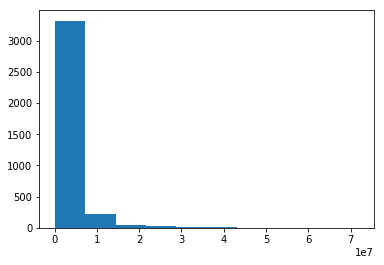

In [17]:
plt.hist(test_target_val)

(array([1.396e+04, 3.840e+02, 1.050e+02, 3.600e+01, 1.400e+01, 1.400e+01,
        8.000e+00, 3.000e+00, 1.000e+00, 2.000e+00]),
 array([0.0000e+00, 1.1850e+07, 2.3700e+07, 3.5550e+07, 4.7400e+07,
        5.9250e+07, 7.1100e+07, 8.2950e+07, 9.4800e+07, 1.0665e+08,
        1.1850e+08]),
 <a list of 10 Patch objects>)

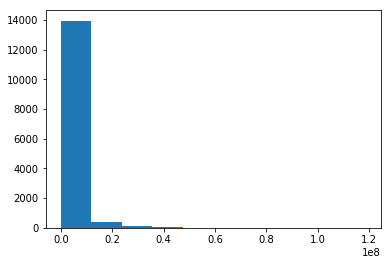

In [18]:
plt.hist(train_target_val)

The distribution of our test and training set look very similar. Just as we wanted them to be.

### 2.2) Baseline models
First, we are applying some models to our data without doing any parameter tuning or dropping any features. The obtained cross-validation, test and training errors can then be used as a baseline as we progress.

Before fitting the models, we scale all numeric features. Since the dataframe only has data of type categorical, float and int, we select the latter two for scaling.

In [19]:
train_predictors_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14527 entries, 11893 to 13818
Columns: 125 entries, Age to Position_Group_Midfielder
dtypes: category(45), float64(43), int64(37)
memory usage: 9.6 MB


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_predictors_val[train_predictors_val.select_dtypes(include=['float64','float32','int64','int32'], exclude=['category']).columns] = scaler.fit_transform(train_predictors_val.select_dtypes(include=['float64','float32','int64','int32'], exclude=['category']))

test_predictors_val[test_predictors_val.select_dtypes(include=['float64','float32','int64','int32'], exclude=['category']).columns] = scaler.fit_transform(test_predictors_val.select_dtypes(include=['float64','float32','int64','int32'],exclude=['category']))


In [21]:
train_predictors_val[train_predictors_val.select_dtypes(include='category').columns]=train_predictors_val[train_predictors_val.select_dtypes(include='category').columns].astype('int')
test_predictors_val[test_predictors_val.select_dtypes(include='category').columns]=test_predictors_val[test_predictors_val.select_dtypes(include='category').columns].astype('int')

In [22]:
train_predictors_val.head()

,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
11893,-0.026879,-0.326537,-0.377531,-1.957513,1,1,2,1,0,0.157975,0.724599,-0.274513,1.433110,1.012672,0.256345,-2.534018,-2.534018,-2.534018,-2.504813,-2.504943,-2.504943,-2.504943,-2.504813,-2.510670,-2.510670,-2.510670,-2.541207,-2.552899,-2.552899,-2.552899,-2.541207,-2.536604,-2.473143,-2.473143,-2.473143,-2.536604,-2.501955,-2.369425,-2.369425,-2.369425,-2.501955,-1.774264,-1.969235,-2.251654,-1.673917,-2.084089,-2.181190,-1.580779,-1.588286,-1.740636,-3.009445,-1.635844,-1.128942,-1.715828,0.016166,-0.908398,-1.532306,-0.933117,-1.141113,-0.347675,-1.767453,-2.168351,-1.140290,-2.089176,-2.710039,-1.304909,-2.761188,-1.316796,-1.408347,-1.387178,2.550967,2.685877,2.758203,2.665921,2.844348,-0.173253,-2.735504,-2.310606,-2.205011,-1.411056,-1.695130,-2.626452,-1.406341,2.735389,-0.012293,2,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2672,2.329249,0.977567,0.273397,0.670659,0,2,2,3,1,0.157975,-0.777071,-0.274513,-1.613802,-1.974715,-0.576948,0.630116,0.630116,0.630116,0.798782,0.816303,0.816303,0.816303,0.798782,0.947259,0.947259,0.947259,0.771154,0.860020,0.860020,0.860020,0.771154,0.249601,0.324490,0.324490,0.324490,0.249601,0.131050,-0.111701,-0.111701,-0.111701,0.131050,1.218376,0.895340,-0.533713,1.178301,1.083172,0.990126,1.408282,1.390602,1.260642,1.298534,-0.302430,-0.857631,0.441535,0.461159,1.695991,0.846964,-2.701805,-0.702148,-0.985416,1.038463,-0.964429,-0.562213,0.721929,1.881990,1.811280,1.257783,-0.264127,0.154115,-0.450233,-0.207226,-0.557767,-0.017901,-0.318153,-0.042934,0.692733,0.318732,0.901504,1.384870,0.312968,-0.379497,0.751068,-0.187339,-0.230296,-0.937608,1,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
9565,0.187314,-0.036736,-0.214799,-1.990457,1,1,2,1,0,-1.157338,-0.689495,-0.274513,0.671382,1.012672,1.217837,-2.534018,-2.534018,-2.534018,-2.504813,-2.504943,-2.504943,-2.504943,-2.504813,-2.510670,-2.510670,-2.510670,-2.541207,-2.552899,-2.552899,-2.552899,-2.541207,-2.536604,-2.473143,-2.473143,-2.473143,-2.536604,-2.501955,-2.369425,-2.369425,-2.369425,-2.501955,-1.991911,-1.662317,-1.965330,-2.420927,-1.914415,-2.181190,-2.015552,-1.588286,-2.393088,-2.171782,-2.102538,-2.146359,-1.041652,1.239896,-1.471509,-2.228678,-0.512001,-1.830915,0.210349,-1.715492,-1.996362,-1.573848,-1.833621,-0.378701,-1.750079,-0.052751,-1.366923,-1.638120,-1.527719,2.944994,2.567926,2.335752,2.724432,2.844348,-0.506325,-2.735504,-2.324046,-2.255395,-1.571017,-1.875354,-1.863786,-1.552621,2.723667,-0.197356,2,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
17906,-1.312040,-2.210243,-0.540263,-0.555577,1,1,3,2,0,0.909583,0.0227

Now that all numerical non-categorical data are scaled and categorical data are converted to integer (the models do not take dtype categorical as input) we proceed with fitting our baseline models.

In [23]:
import sklearn.model_selection as cv
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score, LeaveOneOut

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

dtr=DecisionTreeRegressor()
rfr=RandomForestRegressor()
xbr=xgb.XGBRegressor()
lre=LinearRegression()
svr=SVR()

models = [dtr,rfr,xbr,lre,svr]

for mod in models:
    mod.fit(train_predictors_val, train_target_val)

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:00:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [24]:
test_error = []

# Sequentially fit all models and calculate test score
for mod in models:
    y_pred = mod.predict(test_predictors_val)
    mse_mod = MSE(test_target_val, y_pred)
    rmse_mod = round(mse_mod**(1/2))
    test_error.append(rmse_mod)

In [25]:
cv_error=[]

for mod in models:
    MSE_cv_error = -cross_val_score(mod, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
    RMSE_cv = round((MSE_cv_error.mean())**(1/2))
    cv_error.append(RMSE_cv)

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [26]:
train_error=[]

# Sequentially fit all models and calculate train score
for mod in models:
    y_pred = mod.predict(train_predictors_val)
    mse_mod = MSE(train_target_val, y_pred)
    rmse_mod = round(mse_mod**(1/2))
    train_error.append(rmse_mod)

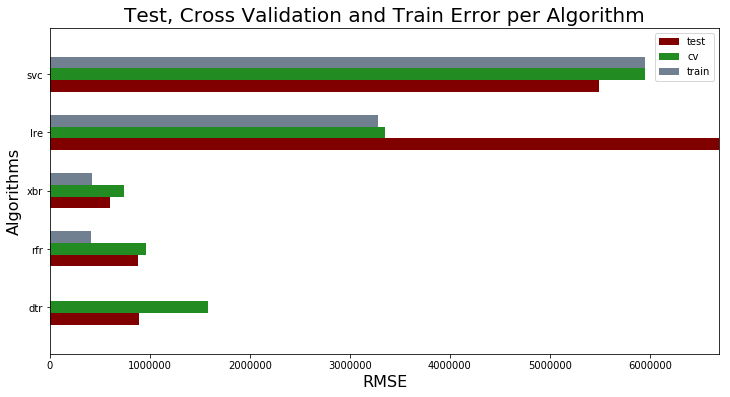

In [27]:
model_names = ['dtr','rfr','xbr','lre','svc']

error = pd.DataFrame(dict(graph=model_names,test_error=test_error, cv_error=cv_error, train_error=train_error)) 

ind = np.arange(len(error))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))
ax.barh(ind, error.test_error, width, color='maroon', label='test')
ax.barh(ind + width, error.cv_error, width, color='forestgreen', label='cv')
ax.barh(ind + 2*width, error.train_error, width, color='slategrey', label='train')
ax.set_xlim(0, max(error.cv_error)+min(error.cv_error))
plt.xlabel('RMSE', fontsize=16)
plt.ylabel('Algorithms', fontsize=16)
plt.title('Test, Cross Validation and Train Error per Algorithm',fontsize=20)

ax.set(yticks=ind + width, yticklabels=error.graph, ylim=[2*width - 1, len(error)])
ax.legend()

plt.show()


In [28]:
error

,graph,test_error,cv_error,train_error
0,dtr,8.899300e+05,1582050.0,0.0
1,rfr,8.853950e+05,963003.0,412169.0
2,xbr,6.058860e+05,742355.0,423097.0
3,lre,6.421262e+16,3353246.0,3277148.0
4,svc,5.491672e+06,5952538.0,5954762.0


While the Support Vector Regression is the most stable model, we can see that the Linear Regression has a very high test error (and, therefore, is overfit). The Decision Tree Regressor is also overfit, as its train error is zero. XGBoost and Random Forest also need some complexity reduction.<br>

In general, the errors are fluctuating between 500K and 6M, which serves as a good first impression.

### 2.3) Feature selection based on feature importance
Next, we are looking at the respective features to find out which ones have the most explanatory power and which ones should not be considered or could be transformed for further analysis. First we are looking at the features using SelectKBest from the sklearn package. As an evaluation criteria we are using the F-value for each respective feature.

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

X = train_predictors_val  
y = train_target_val
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores['Expl_percent']=(featureScores['Score']/featureScores['Score'].sum())*100
featureScores.nlargest(125,'Score')

,Specs,Score,Expl_percent
5,International Reputation,10926.667128,1.020489e+01
1,Overall,9247.932429,8.637050e+00
75,Club_Reputation,8635.202466,8.064794e+00
2,Potential,7144.411856,6.672479e+00
54,Reactions,5942.582653,5.550038e+00
66,Composure,3632.566134,3.392613e+00
8,Real Face,3565.014584,3.329523e+00
3,Special,2416.453120,2.256832e+00
64,Vision,2126.810904,1.986322e+00
81,Mentality,1937.306594,1.809336e+00


From the F-values, we can see that International Reputation, Overall score, Club Reputation, Potential, Reactions, Real Face, Composure, Special, Vision and Mentality are the ten most important features. Height, Loaned From, Body Type and a couple of position features are among the ten least important features. 

To confirm our findings, we are also running an ExtraTreeRegressor and extract the feature importance. Feature importance gives back a score. A more important feature is indicated by a higher score.

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



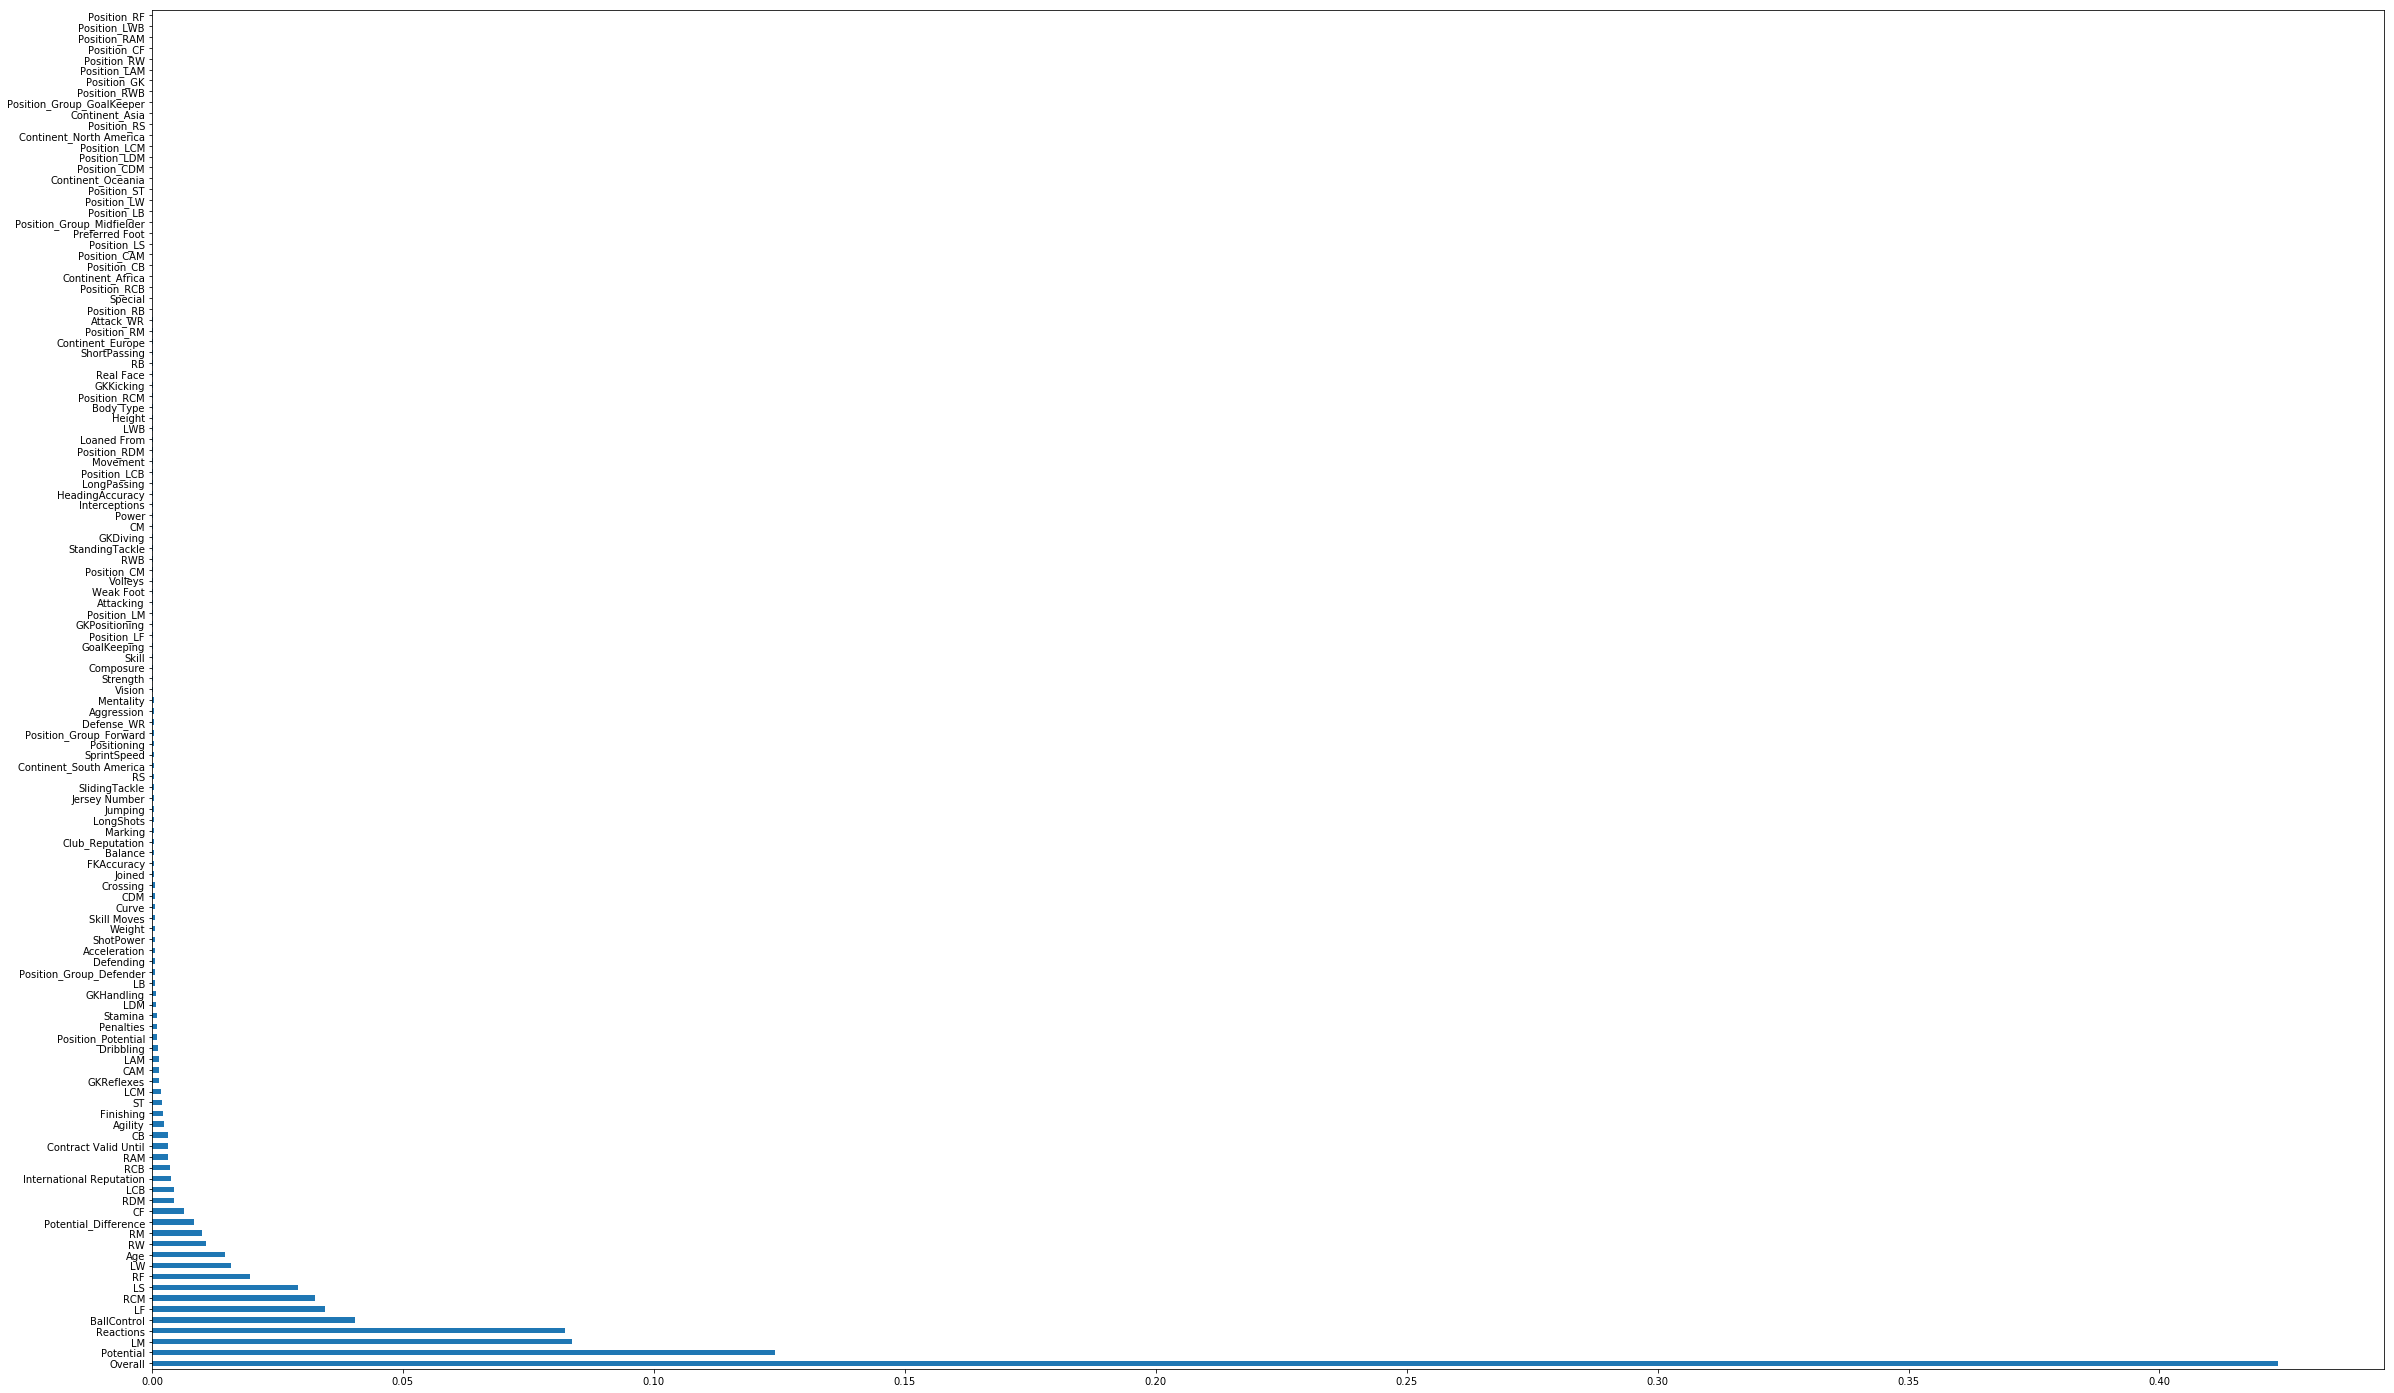

In [30]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(X,y)

#plot graph of feature importances for better visualization
fig, ax = plt.subplots(figsize=(40,25))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(125).plot(kind='barh')

plt.show()

Based on the ExtraTreeRegressor scores, the following features are the ten most important:<br>
- Overall
- Potential
- LAM
- RF
- International Reputation
- Ball Control
- Position Potential
- Reactions
- LF
- Age

Some of the features are in line with the F-scores, however, some features vary vastly in their importance between the two methods. E.g., Real Face is very important according to F-score, but not at all according to ExtraTreeRegressor. Same goes for Special. Reversely, Age is very important according to ExtraTreeRegressor, but not si much based on its F-value.

Additionally, we are also looking at the RMSE when using each individual feature as a stand alone predictor for the player's value. To do so, we are running each model using only the repsective feature. We then calculate the RMSE and compare the results. The features with a higher RMSE relative to the others are considered to have less explanatory power (WARNING: This is not taking effects between features into consideration).

In [31]:
n_feats=predictors_df.shape[1]
col_names=pd.DataFrame(np.array(predictors_df.columns))

In [32]:
cv_score_features=pd.DataFrame()
best_models=[dtr,rfr,xbr,lre,svr]
index=0

for mod in best_models:
    score_list=[]
    index+=1
    for i in range(n_feats):
        X_feature = pd.DataFrame(np.array(predictors_df.iloc[:, i]).reshape(-1,1))
        scores = -cross_val_score(mod, X_feature, target_val, scoring='neg_mean_squared_error', n_jobs=-1)
        score_list.append(scores.mean())
    cv_score_features[str(index)]=score_list

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [33]:
s = {'Feature': col_names[0],
     'DTR': cv_score_features['1'],
     'RFR': cv_score_features['2'],
     'XBR': cv_score_features['3'],
     'LRE': cv_score_features['4'],
     'SVC': cv_score_features['5']}
feature_scores=pd.DataFrame(data=s)
feature_scores=feature_scores.sort_values(by=['XBR'])
feature_scores

,Feature,DTR,RFR,XBR,LRE,SVC
1,Overall,3.291131e+13,3.294635e+13,3.291657e+13,6.343037e+13,3.559205e+13
50,BallControl,3.363363e+13,3.431617e+13,3.359435e+13,3.976522e+13,3.559360e+13
22,RW,3.404289e+13,3.425635e+13,3.403353e+13,4.016000e+13,3.559329e+13
18,LW,3.404289e+13,3.418134e+13,3.403353e+13,4.016000e+13,3.559329e+13
23,LAM,3.503860e+13,3.495623e+13,3.501742e+13,4.009771e+13,3.559356e+13
25,RAM,3.503860e+13,3.493453e+13,3.501742e+13,4.009771e+13,3.559356e+13
24,CAM,3.503860e+13,3.500816e+13,3.501742e+13,4.009771e+13,3.559356e+13
21,RF,3.510001e+13,3.507777e+13,3.507277e+13,4.010982e+13,3.559353e+13
19,LF,3.510001e+13,3.516358e+13,3.507277e+13,4.010982e+13,3.559353e+13
20,CF,3.510001e+13,3.506381e+13,3.507277e+13,4.010982e+13,3.559353e+13


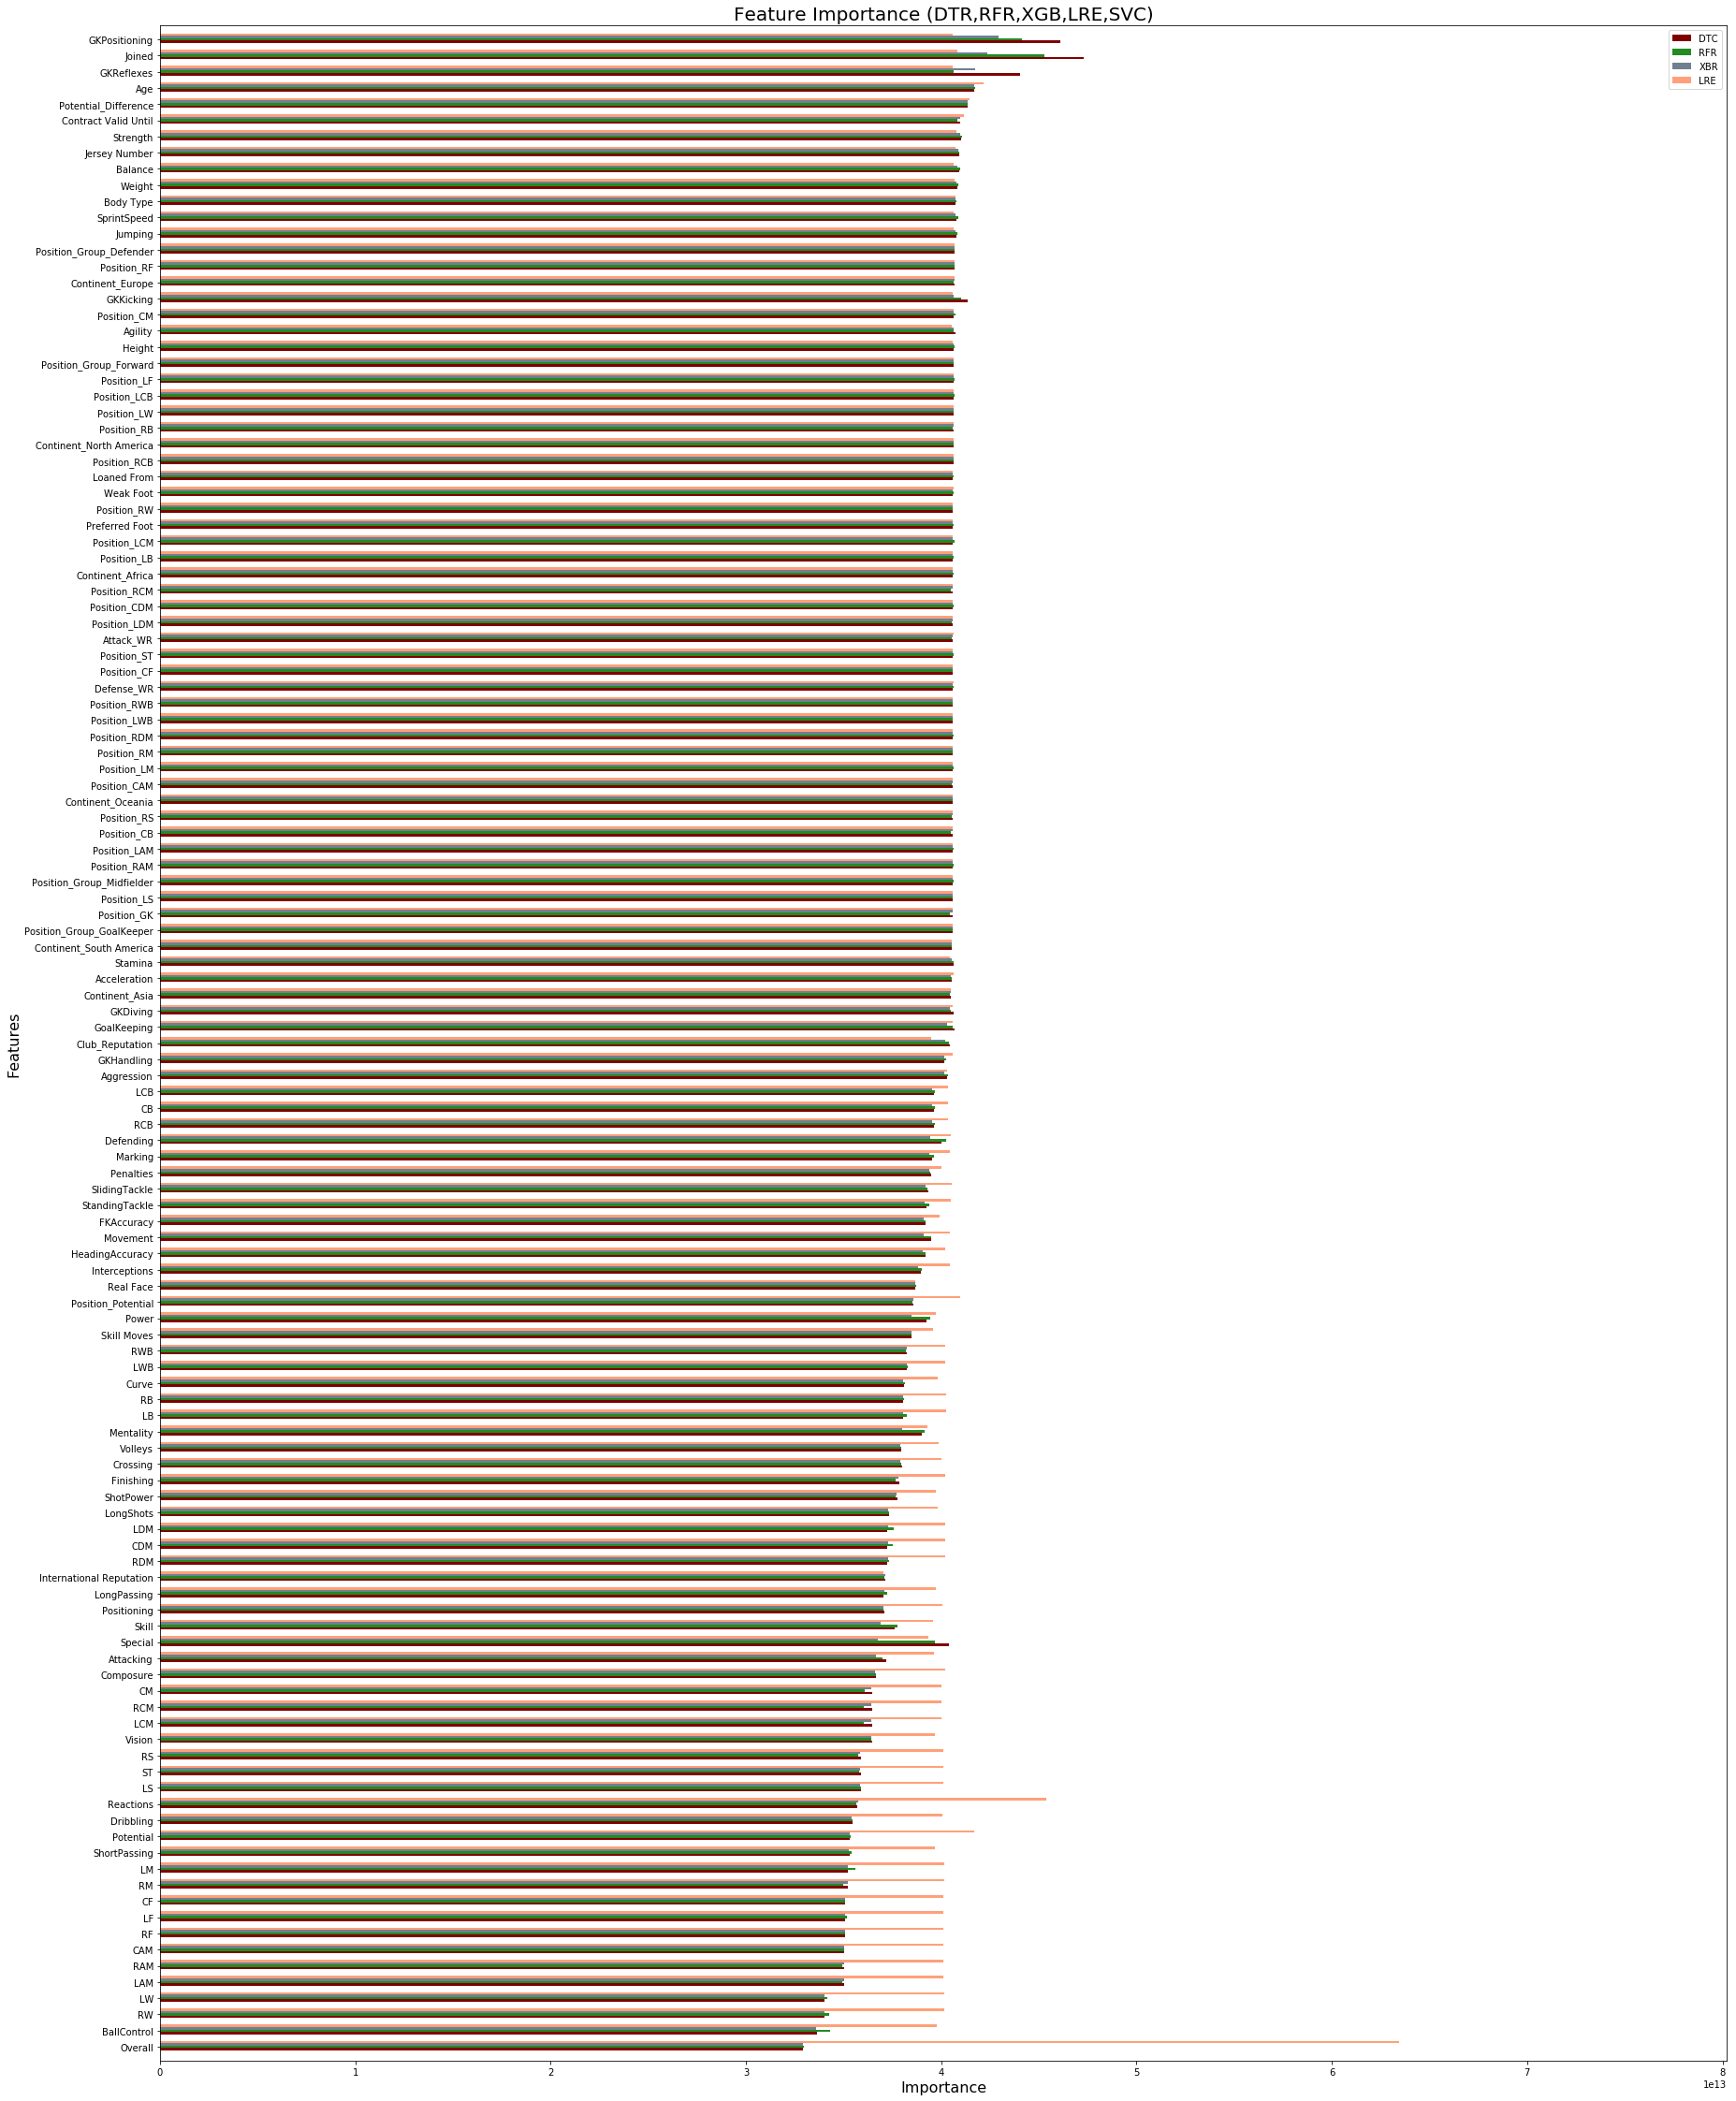

In [34]:
importance = pd.DataFrame(dict(graph=feature_scores['Feature'],
                               DTR=feature_scores['DTR'],
                               RFR=feature_scores['RFR'],
                               XBR=feature_scores['XBR'],
                               LRE=feature_scores['LRE'],
                               SVC=feature_scores['SVC'])) 

ind = np.arange(len(importance))
width = 0.15

fig, ax = plt.subplots(figsize=(30,40))
ax.barh(ind, importance.DTR, width, color='maroon', label='DTC')
ax.barh(ind + width, importance.RFR, width, color='forestgreen', label='RFR')
ax.barh(ind + 2*width, importance.XBR, width, color='slategrey', label='XBR')
ax.barh(ind + 3*width, importance.LRE, width, color='lightsalmon', label='LRE')
ax.set_xlim(0, max(importance.DTR)+min(importance.DTR))
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.title('Feature Importance (DTR,RFR,XGB,LRE,SVC)',fontsize=20)

ax.set(yticks=ind + width, yticklabels=importance.graph, ylim=[2*width - 1, len(importance)])
ax.legend()

plt.show()

According to this method, some position skills, as well as Ball Control and the Overall score are the ten most important features for a low RMSE. 

Based on our feature importance analysis, we are making the following modifications:
- Group position skills into 'Forward Skills', 'Midfield Skills' and 'Defence Skills' and drop single position skills to avoid overemphasizing these features
- Drop individual position dummies and only keep the grouped position dummies to avoid duplication of features
- Drop all features for that the F-value makes up less than one percent of the summ of all F-values, EXCEPT for when one of these features is within the top ten features for either the ExtraTreeRegressor or the single feature RMSE.

Grouping position skills and drop single position skills:

In [35]:
predictors_df['Forward_Skill'] = predictors_df.loc[:,['LS',  'ST', 'RS',  'LW', 'LF', 'CF', 'RF', 'RW']].mean(axis=1)

predictors_df['Midfield_Skill'] = predictors_df.loc[:,['LAM','CAM','RAM', 'LM', 'LCM', 'CM' ,'RCM', 'RM','LDM', 'CDM', 'RDM']].mean(axis=1)

predictors_df['Defence_Skill'] = predictors_df.loc[:,['LWB','RWB', 'LB','LCB','CB','RCB','RB']].mean(axis=1)

predictors_df = predictors_df.drop(['LS',  'ST', 'RS',  'LW', 'LF', 'CF', 'RF', 'RW',
          'LAM','CAM','RAM', 'LM', 'LCM', 'CM' ,'RCM', 'RM','LDM', 'CDM', 'RDM',
          'LWB','RWB', 'LB','LCB','CB','RCB','RB'], axis = 1)

Drop individual position dummies and only keep grouped position dummies:

In [36]:
predictors_df=predictors_df.drop(predictors_df.iloc[:,predictors_df.columns.get_loc('Position_CAM'):predictors_df.columns.get_loc('Position_ST')+1], axis=1)

Next, we are dropping all features for which the F-value makes up less than one percent of the total sum of F-values, and which are not among the top ten features neither for RMSE nor ExtraTreeRegressor. To do so, we are indexing the most important features first, extract all values that we do not want to keep and use these as our index in the drop function. Also, we are keeping the Position Groups (Goalkeeper, Defender, Midfielder, Forward), since Goalkeepers have a significantly different value distribution than the other groups. We, therefore, think it will be important to take this into account.

In [37]:
predictors_df.head()

,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder,Forward_Skill,Midfield_Skill,Defence_Skill
0,31,94,94,2202,0,5.0,4.0,4.0,1,10.0,5297,0,3,170,159,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,2.242424,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,1,2,2,0,0,0,0,0,1,0,1,0,0,90.875,81.454545,55.285714
1,33,94,94,2228,1,5.0,4.0,5.0,1,7.0,175,0,4,188,183,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,2.520000,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,2,3,1,0,0,1,0,0,0,0,1,0,0,90.125,78.727273,58.714286
2,26,92,93,2143,1,5.0,5.0,5.0,1,10.0,516,0,4,175,150,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,2.233333,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,1,3,2,0,0,0,0,0,1,0,1,0,0,87.125,78.727273,55.857143
3,27,91,93,1471,1,4.0,3.0,1.0,1,1.0,2741,0,2,193,168,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,2.090909,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,1,2,2,0,0,1,0,0,0,0,0,1,0,0.000,0.000000,0.000000
4,27,91,92,2281,1,4.0,5.0,4.0,1,7.0,1220,0,5,180,154,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,2.090909,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,2,3,3,0,0,1,0,0,0,0,0,0,1,85.125,84.727273,71.142857


In [38]:
featureScores_topten=list(featureScores.sort_values(by='Expl_percent', ascending=False)[0:10]['Specs'])
feat_importances_topten=list(feat_importances.sort_values(ascending=False)[0:10].index.values)
feature_scores_topten=list(feature_scores[0:10]['Feature'])
Position_features=['Position_Group_Defender','Position_Group_Forward','Position_Group_GoalKeeper','Position_Group_Midfielder']
features_keep=list(set(featureScores_topten+feat_importances_topten+feature_scores_topten+Position_features))

In [39]:
# Matching features to keep with features left in predictors_df
features_keep=set(features_keep)& set(predictors_df.columns)

In [40]:
features_drop=predictors_df.columns.drop(features_keep)

In [41]:
predictors_df=predictors_df.drop(features_drop,axis=1)

In [42]:
predictors_df.head()

,Overall,Potential,Special,International Reputation,Real Face,BallControl,Reactions,Vision,Composure,Club_Reputation,Mentality,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
0,94,94,2202,5.0,1,96.0,95.0,94.0,96.0,2.242424,71.500000,0,1,0,0
1,94,94,2228,5.0,1,94.0,96.0,82.0,95.0,2.520000,74.833333,0,1,0,0
2,92,93,2143,5.0,1,95.0,94.0,87.0,94.0,2.233333,73.833333,0,1,0,0
3,91,93,1471,4.0,1,42.0,90.0,68.0,68.0,2.090909,42.666667,0,0,1,0
4,91,92,2281,4.0,1,91.0,91.0,94.0,88.0,2.090909,80.833333,0,0,0,1


We can use the reduced data frame for predicting values again now, and compare the results to our baseline models.

### 2.4) Prediction on reduced dataset

We first split the data into train and test set. As before, we are using stratified sampling evenly distribute the outliers among samples.

In [43]:
train_predictors_val, test_predictors_val, train_target_val, test_target_val = train_test_split(predictors_df,
                                                                                                target_val,
                                                                                                test_size=0.2,
                                                                                                stratify=y_binned)

Before using the data for prediction, we have to scale them again as we did in the beginning.

In [44]:
scaler = StandardScaler()

train_predictors_val[train_predictors_val.select_dtypes(include=['float64','float32','int64','int32'], exclude=['category']).columns] = scaler.fit_transform(train_predictors_val.select_dtypes(include=['float64','float32','int64','int32'], exclude=['category']))

test_predictors_val[test_predictors_val.select_dtypes(include=['float64','float32','int64','int32'], exclude=['category']).columns] = scaler.fit_transform(test_predictors_val.select_dtypes(include=['float64','float32','int64','int32'],exclude=['category']))


In [45]:
train_predictors_val[train_predictors_val.select_dtypes(include='category').columns]=train_predictors_val[train_predictors_val.select_dtypes(include='category').columns].astype('int')
test_predictors_val[test_predictors_val.select_dtypes(include='category').columns]=test_predictors_val[test_predictors_val.select_dtypes(include='category').columns].astype('int')

After we have prepared the train and test split, we fit the models and calculate the respective CV, Train and Test errors.

In [46]:
dtr=DecisionTreeRegressor()
rfr=RandomForestRegressor()
xbr=xgb.XGBRegressor()
lre=LinearRegression()
svr=SVR()

models = [dtr,rfr,xbr,lre,svr]

for mod in models:
    mod.fit(train_predictors_val, train_target_val)

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:37:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [47]:
test_error = []

# Sequentially fit all models and calculate test score
for mod in models:
    y_pred = mod.predict(test_predictors_val)
    mse_mod = MSE(test_target_val, y_pred)
    rmse_mod = round(mse_mod**(1/2))
    test_error.append(rmse_mod)

In [48]:
cv_error=[]

for mod in models:
    MSE_cv_error = -cross_val_score(mod, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
    RMSE_cv = round((MSE_cv_error.mean())**(1/2))
    cv_error.append(RMSE_cv)

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [49]:
train_error=[]

# Sequentially fit all models and calculate train score
for mod in models:
    y_pred = mod.predict(train_predictors_val)
    mse_mod = MSE(train_target_val, y_pred)
    rmse_mod = round(mse_mod**(1/2))
    train_error.append(rmse_mod)

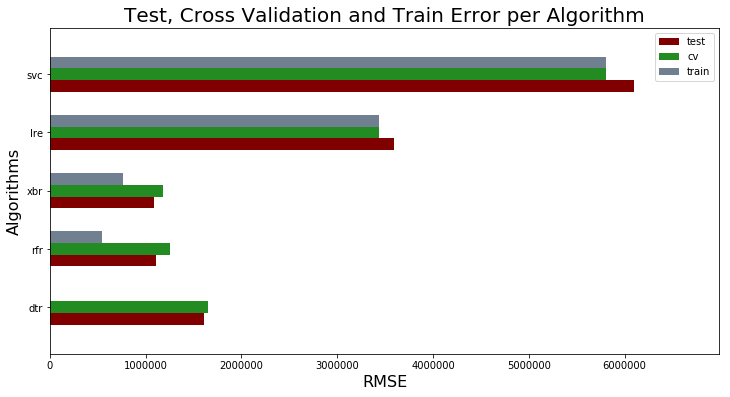

In [50]:
model_names = ['dtr','rfr','xbr','lre','svc']

error = pd.DataFrame(dict(graph=model_names,test_error=test_error, cv_error=cv_error, train_error=train_error)) 

ind = np.arange(len(error))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))
ax.barh(ind, error.test_error, width, color='maroon', label='test')
ax.barh(ind + width, error.cv_error, width, color='forestgreen', label='cv')
ax.barh(ind + 2*width, error.train_error, width, color='slategrey', label='train')
ax.set_xlim(0, max(error.cv_error)+min(error.cv_error))
plt.xlabel('RMSE', fontsize=16)
plt.ylabel('Algorithms', fontsize=16)
plt.title('Test, Cross Validation and Train Error per Algorithm',fontsize=20)

ax.set(yticks=ind + width, yticklabels=error.graph, ylim=[2*width - 1, len(error)])
ax.legend()

plt.show()


In [51]:
error

,graph,test_error,cv_error,train_error
0,dtr,1607480.0,1652020.0,0.0
1,rfr,1109561.0,1252162.0,539757.0
2,xbr,1084035.0,1185917.0,765875.0
3,lre,3587924.0,3438748.0,3434508.0
4,svc,6097043.0,5803173.0,5805194.0


Compared to our first baseline model, the linear regression became a lot more stable, as the test error reduced significantly. The other models where almost uneffected by the reduced data frame. This means we did not loose any predictive power by reducing our dataset, and can continue with the parameter tuning. Decision Tree, Random Forest and XGBoost look most promising.

Final look at the feature importance:

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



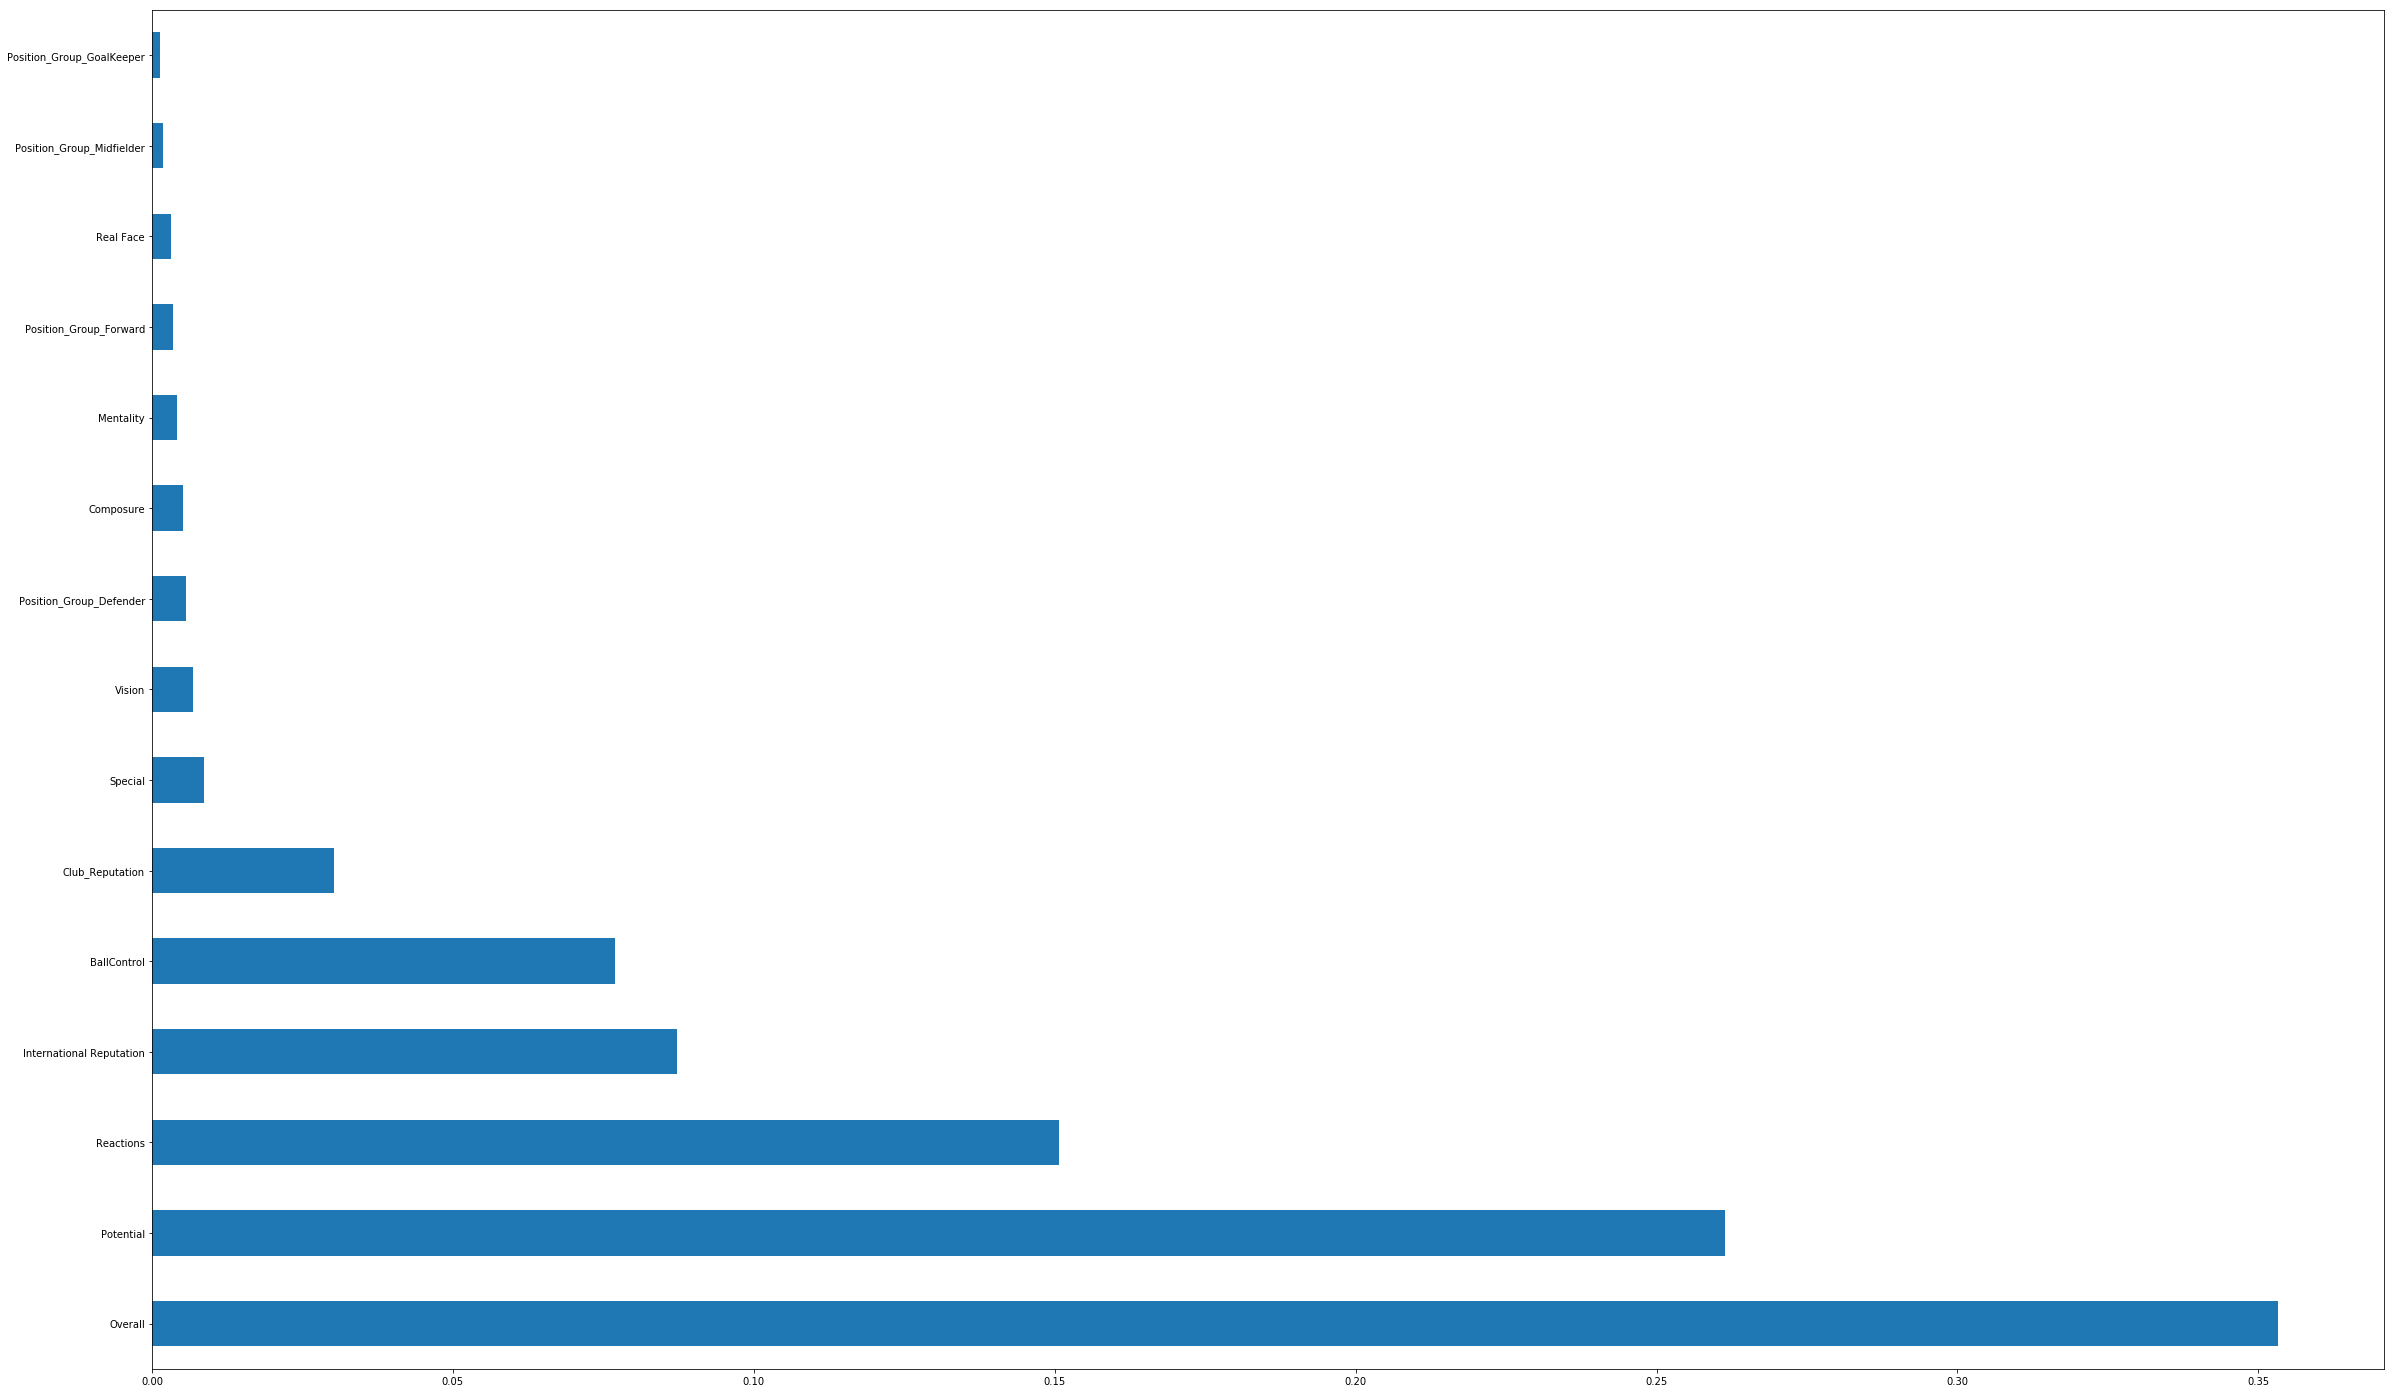

In [52]:
model = ExtraTreesRegressor()

X = train_predictors_val  
y = train_target_val

model.fit(X,y)

#plot graph of feature importances for better visualization
fig, ax = plt.subplots(figsize=(40,25))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(125).plot(kind='barh')

plt.show()

## 3.) Parameter tuning

We are using GridSearch to iterate over a list of possible parameters for the most important parameters of each model.

### 3.1) Decision Tree Regressor

We are starting by tuning parameters for the Decision Tree Regressor. As most important features we are identifying the maximum depth, minimum sample leafs, minimum sample split and the maximum number of features to be considered when for the best split. As we can see from the baseline model, the Decision Tree Regressor at this point is highly overfit. 

**Default settings:**<br>
DecisionTreeRegressor(criterion=’mse’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, presort=False)

In [53]:
from sklearn.model_selection import GridSearchCV

# Parameter's to search
max_depth = [1,2,3,4,5,6,7,8,9,10]
min_samples_split = [0.1,0.3,0.5,0.7,2]
min_samples_leaf = [1,2,3,4]
max_features = [1,2,3,4]

# Setting up parameter grid
hyperparams = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 
               'max_features': max_features}

# Run GridSearch CV
gd=GridSearchCV(estimator = dtr, param_grid = hyperparams, 
                verbose=True, cv=10, scoring = 'neg_mean_squared_error')

# Fitting model and return results
gd.fit(train_predictors_val, train_target_val)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-2856077542264.771
DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=4,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


[Parallel(n_jobs=1)]: Done 8000 out of 8000 | elapsed:  2.3min finished


After using GridSearch to identify the best parameters for minimizing the mean squared error, we also have to make sure the model is not under- or overfit.

In [54]:
dtr=DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=4,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

dtr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = dtr.predict(test_predictors_val)
test_mse_dtr = MSE(test_target_val, y_pred)
test_rmse_dtr = round(test_mse_dtr**(1/2))

In [55]:
# Cross-validation error
MSE_cv_error_dtr = -cross_val_score(dtr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_dtr = round((MSE_cv_error_dtr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [56]:
# Train error
y_pred = dtr.predict(train_predictors_val)
train_mse_dtr = MSE(train_target_val, y_pred)
train_rmse_dtr = round(train_mse_dtr**(1/2))

In [57]:
pd.DataFrame([test_rmse_dtr,RMSE_cv_dtr,train_rmse_dtr], 
             index=['Test error','CV error','Train error'], 
             columns=['DTR errors'])

,DTR errors
Test error,1817524.0
CV error,1777679.0
Train error,1211908.0


The train error is significantly lower than the test and cv error, which is an indicator for overfitting. Therefore, we are manually reducing complexity beginning with the optimized parameters model.

We recognized that we the maximum depth is quite high. A high maximum depth is more prone to overfitting. We try to reduce the depth to six.

In [58]:

dtr=DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=4,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

dtr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = dtr.predict(test_predictors_val)
test_mse_dtr = MSE(test_target_val, y_pred)
test_rmse_dtr = round(test_mse_dtr**(1/2))

In [59]:
# Cross-validation error
MSE_cv_error_dtr = -cross_val_score(dtr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_dtr = round((MSE_cv_error_dtr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [60]:
# Train error
y_pred = dtr.predict(train_predictors_val)
train_mse_dtr = MSE(train_target_val, y_pred)
train_rmse_dtr = round(train_mse_dtr**(1/2))

In [61]:
pd.DataFrame([test_rmse_dtr,RMSE_cv_dtr,train_rmse_dtr], 
             index=['Test error','CV error','Train error'], 
             columns=['DTR errors'])

,DTR errors
Test error,1990149.0
CV error,1961092.0
Train error,1774496.0


The model still shows some overfitting, but at least the CV and training error are closer now. However, we need to further reduce complexity. We do so by increasing the minimum sample leaf from three to five.

In [62]:

dtr=DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=4,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

dtr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = dtr.predict(test_predictors_val)
test_mse_dtr = MSE(test_target_val, y_pred)
test_rmse_dtr = round(test_mse_dtr**(1/2))

In [63]:
# Cross-validation error
MSE_cv_error_dtr = -cross_val_score(dtr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_dtr = round((MSE_cv_error_dtr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [64]:
# Train error
y_pred = dtr.predict(train_predictors_val)
train_mse_dtr = MSE(train_target_val, y_pred)
train_rmse_dtr = round(train_mse_dtr**(1/2))

In [65]:
pd.DataFrame([test_rmse_dtr,RMSE_cv_dtr,train_rmse_dtr], 
             index=['Test error','CV error','Train error'], 
             columns=['DTR errors'])

,DTR errors
Test error,2261811.0
CV error,1972206.0
Train error,1724263.0


CV and train error are pretty much aligned now. The test error is still too high though. Further complexity reduction by increasing the minimum sample split.

In [66]:

dtr=DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=4,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

dtr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = dtr.predict(test_predictors_val)
test_mse_dtr = MSE(test_target_val, y_pred)
test_rmse_dtr = round(test_mse_dtr**(1/2))

In [67]:
# Cross-validation error
MSE_cv_error_dtr = -cross_val_score(dtr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_dtr = round((MSE_cv_error_dtr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [68]:
# Train error
y_pred = dtr.predict(train_predictors_val)
train_mse_dtr = MSE(train_target_val, y_pred)
train_rmse_dtr = round(train_mse_dtr**(1/2))

In [69]:
pd.DataFrame([test_rmse_dtr,RMSE_cv_dtr,train_rmse_dtr], 
             index=['Test error','CV error','Train error'], 
             columns=['DTR errors'])

,DTR errors
Test error,2315590.0
CV error,1964846.0
Train error,1731071.0


In [70]:
print(round(test_rmse_dtr/RMSE_cv_dtr,4))
print(round(train_rmse_dtr/RMSE_cv_dtr,4))

1.1785
0.881


The test error and the CV error show difference of less than five percent (difference for the train error is higher, but this is fluctuating a lot and, therefore, not reliable). We, therefore, assume approximately now under- or overfitting.

### 3.2) Random Forest Regressor

We repeat the same process as before for the Random Forest Regressor. Since Random Forest equals a collection of multiple decision trees, we identify the same parameters as for Decision Tree to be the most important ones. We add only one parameter, namely the number of trees in the forest.

**Default Settings:**<br>
RandomForestRegressor(n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [71]:
# Parameter's to search
n_estimators = [5,10,100]
max_depth = [1,4,8]
min_samples_split = [0.1,0.5,2]
min_samples_leaf = [1,2,4]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators,
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Run GridSearch CV
gd=GridSearchCV(estimator = rfr, param_grid = hyperparams, 
                verbose=True, cv=3, scoring = 'neg_mean_squared_error')

# Fitting model and return results
gd.fit(train_predictors_val, train_target_val)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  1.1min finished


-1365217956288.885
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


After using GridSearch to identify the best parameters for minimizing the mean squared error, we also have to make sure the model is not under- or overfit.

In [72]:
rfr=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

rfr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = rfr.predict(test_predictors_val)
test_mse_rfr = MSE(test_target_val, y_pred)
test_rmse_rfr = round(test_mse_rfr**(1/2))

In [73]:
# Cross-validation error
MSE_cv_error_rfr = -cross_val_score(rfr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_rfr = round((MSE_cv_error_rfr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [74]:
# Train error
y_pred = rfr.predict(train_predictors_val)
train_mse_rfr = MSE(train_target_val, y_pred)
train_rmse_rfr = round(train_mse_rfr**(1/2))

In [75]:
pd.DataFrame([test_rmse_rfr,RMSE_cv_rfr,train_rmse_rfr], 
             index=['Test error','CV error','Train error'], 
             columns=['RFR errors'])

,RFR errors
Test error,1140582.0
CV error,1165992.0
Train error,748189.0


The CV error is higher than the test error, which can be interpreted as a sign for underfitting (even though the train error is lower than the test error, but that measurement is highly fluctuating). Therefore, we are increasing complexity. First, we are decreasing the the minimum sample leaf to 0.5 and increase the minimum sample split to 200 (as GridSearch chose the highest value for this parameter, so higher values might perform even better).

In [76]:
rfr=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

rfr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = rfr.predict(test_predictors_val)
test_mse_rfr = MSE(test_target_val, y_pred)
test_rmse_rfr = round(test_mse_rfr**(1/2))

In [77]:
# Cross-validation error
MSE_cv_error_rfr = -cross_val_score(rfr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_rfr = round((MSE_cv_error_rfr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [78]:
# Train error
y_pred = rfr.predict(train_predictors_val)
train_mse_rfr = MSE(train_target_val, y_pred)
train_rmse_rfr = round(train_mse_rfr**(1/2))

In [79]:
pd.DataFrame([test_rmse_rfr,RMSE_cv_rfr,train_rmse_rfr], 
             index=['Test error','CV error','Train error'], 
             columns=['RFR errors'])

,RFR errors
Test error,5837430.0
CV error,5540566.0
Train error,5540533.0


In [80]:
print(round(test_rmse_rfr/RMSE_cv_rfr,4))
print(round(train_rmse_rfr/RMSE_cv_rfr,4))

1.0536
1.0


Train and CV error show virtually no difference, and the difference between CV and test error is below four percent. Therefore, we assume no significant under- or overfitting.

### 3.3) Extreme Gradient Boosting (XGB Regressor)




Helpful information on XGBoost parameter tuning:
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [81]:
max_depth = [1,4,8]
min_child_weight = [1,4,6]
gamma = [0,0.5]
eta = [0.1,0.2,0.3]
subsample = [0.5,1]

# Setting up parameter grid
hyperparams = {'max_depth': max_depth,
               'min_child_weight': min_child_weight, 
               'gamma': gamma,
               'eta': eta,
              'subsample': subsample}

# Run GridSearch CV
gd=GridSearchCV(estimator = xbr, param_grid = hyperparams, 
                verbose=True, cv=3, scoring = 'neg_mean_squared_error')

# Fitting model and return results
gd.fit(train_predictors_val, train_target_val)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[14:46:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:46:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:47:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:48:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:49:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  4.6min finished
C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:50:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
-1146679041680.3508
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=6, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)


In [82]:
xbr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=6, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)

xbr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = xbr.predict(test_predictors_val)
test_mse_xbr = MSE(test_target_val, y_pred)
test_rmse_xbr = round(test_mse_xbr**(1/2))

[14:52:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [83]:
# Cross-validation error
MSE_cv_error_xbr = -cross_val_score(xbr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_xbr = round((MSE_cv_error_xbr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [84]:
# Train error
y_pred = xbr.predict(train_predictors_val)
train_mse_xbr = MSE(train_target_val, y_pred)
train_rmse_xbr = round(train_mse_xbr**(1/2))

In [85]:
pd.DataFrame([test_rmse_xbr,RMSE_cv_xbr,train_rmse_xbr], 
             index=['Test error','CV error','Train error'], 
             columns=['XBR errors'])

,XBR errors
Test error,1068804.0
CV error,1070831.0
Train error,580964.0


Once again, as for Random Forest, the model shows signs of underfitting (since the test error is lower than the cross-validation error). Also, train error and cv error do not align. We increase complexity by decreasing the subsample (also, setting number of estimates to 140, as GridSearch chose the maximum number given, which indicates that more estimators might be needed; 140 equals one percent of the training dataset).

In [126]:
xbr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=6, missing=None, n_estimators=140,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=.15, verbosity=1)

xbr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = xbr.predict(test_predictors_val)
test_mse_xbr = MSE(test_target_val, y_pred)
test_rmse_xbr = round(test_mse_xbr**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:57:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [127]:
# Cross-validation error
MSE_cv_error_xbr = -cross_val_score(xbr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_xbr = round((MSE_cv_error_xbr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [128]:
# Train error
y_pred = xbr.predict(train_predictors_val)
train_mse_xbr = MSE(train_target_val, y_pred)
train_rmse_xbr = round(train_mse_xbr**(1/2))

In [129]:
pd.DataFrame([test_rmse_xbr,RMSE_cv_xbr,train_rmse_xbr], 
             index=['Test error','CV error','Train error'], 
             columns=['XBR errors'])

,XBR errors
Test error,1186515.0
CV error,1273765.0
Train error,899196.0


Train and CV error came a little bit closer toghether. However, the overall error also increased. Next, we are trying to decrease the variance in the model by reducing the maximum depth.

In [146]:
xbr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=6, missing=None, n_estimators=140,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=.15, verbosity=1)

xbr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = xbr.predict(test_predictors_val)
test_mse_xbr = MSE(test_target_val, y_pred)
test_rmse_xbr = round(test_mse_xbr**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:58:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [147]:
# Cross-validation error
MSE_cv_error_xbr = -cross_val_score(xbr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_xbr = round((MSE_cv_error_xbr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [148]:
# Train error
y_pred = xbr.predict(train_predictors_val)
train_mse_xbr = MSE(train_target_val, y_pred)
train_rmse_xbr = round(train_mse_xbr**(1/2))

In [149]:
pd.DataFrame([test_rmse_xbr,RMSE_cv_xbr,train_rmse_xbr], 
             index=['Test error','CV error','Train error'], 
             columns=['XBR errors'])

,XBR errors
Test error,1186330.0
CV error,1265565.0
Train error,915878.0


Decreasing the maximum depth helped stabilizing the model variance. However, it looks like it is still some tuning needed. 

A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split. Therefore, we are increasing gamma to see whether that could improve our results.

In [150]:
xbr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0.5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=6, missing=None, n_estimators=140,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=.15, verbosity=1)

xbr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = xbr.predict(test_predictors_val)
test_mse_xbr = MSE(test_target_val, y_pred)
test_rmse_xbr = round(test_mse_xbr**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:59:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [151]:
# Cross-validation error
MSE_cv_error_xbr = -cross_val_score(xbr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_xbr = round((MSE_cv_error_xbr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [152]:
# Train error
y_pred = xbr.predict(train_predictors_val)
train_mse_xbr = MSE(train_target_val, y_pred)
train_rmse_xbr = round(train_mse_xbr**(1/2))

In [153]:
pd.DataFrame([test_rmse_xbr,RMSE_cv_xbr,train_rmse_xbr], 
             index=['Test error','CV error','Train error'], 
             columns=['XBR errors'])

,XBR errors
Test error,1186330.0
CV error,1265565.0
Train error,915878.0


Changing gamma did not reduce the bias, but increased the variance of the model. Therefore, we are going back to gamma = 0. Instead, we decrease eta (the learning rate per node), to hopefully increase our accuracy.

In [154]:
xbr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0.5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=6, missing=None, n_estimators=140,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=.15, verbosity=1)


xbr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = xbr.predict(test_predictors_val)
test_mse_xbr = MSE(test_target_val, y_pred)
test_rmse_xbr = round(test_mse_xbr**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[15:00:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [155]:
# Cross-validation error
MSE_cv_error_xbr = -cross_val_score(xbr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_xbr = round((MSE_cv_error_xbr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [156]:
# Train error
y_pred = xbr.predict(train_predictors_val)
train_mse_xbr = MSE(train_target_val, y_pred)
train_rmse_xbr = round(train_mse_xbr**(1/2))

In [157]:
pd.DataFrame([test_rmse_xbr,RMSE_cv_xbr,train_rmse_xbr], 
             index=['Test error','CV error','Train error'], 
             columns=['XBR errors'])

,XBR errors
Test error,1186330.0
CV error,1265565.0
Train error,915878.0


Decreasing eta did not help to significantly decrease our RMSE or decrease the variance in the model. In a final attempt, we decrease the minimum sum of weights of all observations required in a child (min_child_weight) to hopefully increase accuracy.

In [166]:
xbr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0.5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=2, missing=None, n_estimators=140,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=.15, verbosity=1)

xbr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = xbr.predict(test_predictors_val)
test_mse_xbr = MSE(test_target_val, y_pred)
test_rmse_xbr = round(test_mse_xbr**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[15:01:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [167]:
# Cross-validation error
MSE_cv_error_xbr = -cross_val_score(xbr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_xbr = round((MSE_cv_error_xbr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [168]:
# Train error
y_pred = xbr.predict(train_predictors_val)
train_mse_xbr = MSE(train_target_val, y_pred)
train_rmse_xbr = round(train_mse_xbr**(1/2))

In [169]:
pd.DataFrame([test_rmse_xbr,RMSE_cv_xbr,train_rmse_xbr], 
             index=['Test error','CV error','Train error'], 
             columns=['XBR errors'])

,XBR errors
Test error,1182594.0
CV error,1142286.0
Train error,773277.0


Doing so does not have a significant effect either. Instead, it even slightly increases variance. Therefore, we accept the variance in the model (before changing min_child_weight) and move on to Linear Regression.

### 3.4) Linear Regression

For Linear Regression, there is not much parameter tuning to do. The only change we are making to the model is to set fit_intercept parameter to False, as we already centered the data before.

**Default model:**
LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)

In [170]:
lre=LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=None)

lre.fit(train_predictors_val, train_target_val)

# Test error
y_pred = lre.predict(test_predictors_val)
test_mse_lre = MSE(test_target_val, y_pred)
test_rmse_lre = round(test_mse_lre**(1/2))

In [171]:
# Cross-validation error
MSE_cv_error_lre = -cross_val_score(lre, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_lre = round((MSE_cv_error_lre.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [172]:
# Train error
y_pred = lre.predict(train_predictors_val)
train_mse_lre = MSE(train_target_val, y_pred)
train_rmse_lre = round(train_mse_lre**(1/2))

In [173]:
pd.DataFrame([test_rmse_lre,RMSE_cv_lre,train_rmse_lre], 
             index=['Test error','CV error','Train error'], 
             columns=['RFR errors'])

,RFR errors
Test error,3587924.0
CV error,3438748.0
Train error,3434508.0


Excluding the intercept term did not change anything for our prediction compared to the base model. Even though the RMSE is quite high, the model shows very stable results.

### 3.5) Epsilon Support Vector Regression


**Default model:**<br>
SVR(kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

In [174]:
C = [0.001, 0.01, 0.1, 1, 10]
gamma = [0.001, 0.01, 0.1, 1]

# Setting up parameter grid
hyperparams = {'C': C,
               'gamma': gamma}

# Run GridSearch CV
gd=GridSearchCV(estimator = svr, param_grid = hyperparams, 
                verbose=True, cv=3, scoring = 'neg_mean_squared_error')

# Fitting model and return results
gd.fit(train_predictors_val, train_target_val)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.5min finished


-33642840426335.918
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [175]:
svr=SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = svr.predict(test_predictors_val)
test_mse_svr = MSE(test_target_val, y_pred)
test_rmse_svr = round(test_mse_svr**(1/2))

In [176]:
# Cross-validation error
MSE_cv_error_svr = -cross_val_score(svr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_svr = round((MSE_cv_error_svr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [177]:
# Train error
y_pred = svr.predict(train_predictors_val)
train_mse_svr = MSE(train_target_val, y_pred)
train_rmse_svr = round(train_mse_svr**(1/2))

In [178]:
pd.DataFrame([test_rmse_svr,RMSE_cv_svr,train_rmse_svr], 
             index=['Test error','CV error','Train error'], 
             columns=['SVR errors'])

,SVR errors
Test error,6091026.0
CV error,5800242.0
Train error,5798892.0


Even though the RMSE itself is quite high, we get very stable results. Lets see whether using different kernels could improve our RMSE. By default, SVR uses the Gaussian RBF kernel. We try to use a linear kernel instead.

In [179]:
svr=SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = svr.predict(test_predictors_val)
test_mse_svr = MSE(test_target_val, y_pred)
test_rmse_svr = round(test_mse_svr**(1/2))

In [180]:
# Cross-validation error
MSE_cv_error_svr = -cross_val_score(svr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_svr = round((MSE_cv_error_svr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [181]:
# Train error
y_pred = svr.predict(train_predictors_val)
train_mse_svr = MSE(train_target_val, y_pred)
train_rmse_svr = round(train_mse_svr**(1/2))

In [182]:
pd.DataFrame([test_rmse_svr,RMSE_cv_svr,train_rmse_svr], 
             index=['Test error','CV error','Train error'], 
             columns=['SVR errors'])

,SVR errors
Test error,5854694.0
CV error,5619461.0
Train error,5560873.0


A Linear kernel did not help much. Next we use a polynomil kernel.

In [183]:
svr=SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = svr.predict(test_predictors_val)
test_mse_svr = MSE(test_target_val, y_pred)
test_rmse_svr = round(test_mse_svr**(1/2))

In [184]:
# Cross-validation error
MSE_cv_error_svr = -cross_val_score(svr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_svr = round((MSE_cv_error_svr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [185]:
# Train error
y_pred = svr.predict(train_predictors_val)
train_mse_svr = MSE(train_target_val, y_pred)
train_rmse_svr = round(train_mse_svr**(1/2))

In [186]:
pd.DataFrame([test_rmse_svr,RMSE_cv_svr,train_rmse_svr], 
             index=['Test error','CV error','Train error'], 
             columns=['SVR errors'])

,SVR errors
Test error,5917741.0
CV error,5690448.0
Train error,5638680.0


As for the linear kernel, our result did not change significantly. Finally, we are using a sigmoid kernel.

In [630]:
svr=SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(train_predictors_val, train_target_val)

# Test error
y_pred = svr.predict(test_predictors_val)
test_mse_svr = MSE(test_target_val, y_pred)
test_rmse_svr = round(test_mse_svr**(1/2))

In [631]:
# Cross-validation error
MSE_cv_error_svr = -cross_val_score(svr, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_cv_svr = round((MSE_cv_error_svr.mean())**(1/2))

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [632]:
# Train error
y_pred = svr.predict(train_predictors_val)
train_mse_svr = MSE(train_target_val, y_pred)
train_rmse_svr = round(train_mse_svr**(1/2))

In [633]:
pd.DataFrame([test_rmse_svr,RMSE_cv_svr,train_rmse_svr], 
             index=['Test error','CV error','Train error'], 
             columns=['SVR errors'])

,SVR errors
Test error,6009328.0
CV error,5823318.0
Train error,5823789.0


Once again, no significant change. In the following, we are using the linear kernel, since that one performed best (even though the differences where marginal).

### 3.6) Final comparison of tuned models

In order to make a decision for a final model, we are comparing the tuned models.

In [187]:
dtr=DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=4,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

rfr=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

xbr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0.5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=6, missing=None, n_estimators=140,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=.15, verbosity=1)

lre=LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=None)

svr=SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

models = [dtr,rfr,xbr,lre,svr]

for mod in models:
    mod.fit(train_predictors_val, train_target_val)

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[15:12:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [188]:
test_error = []

# Sequentially fit all models and calculate test score
for mod in models:
    y_pred = mod.predict(test_predictors_val)
    mse_mod = MSE(test_target_val, y_pred)
    rmse_mod = round(mse_mod**(1/2))
    test_error.append(rmse_mod)

In [189]:
cv_error=[]

for mod in models:
    MSE_cv_error = -cross_val_score(mod, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
    RMSE_cv = round((MSE_cv_error.mean())**(1/2))
    cv_error.append(RMSE_cv)

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [190]:
train_error=[]

# Sequentially fit all models and calculate train score
for mod in models:
    y_pred = mod.predict(train_predictors_val)
    mse_mod = MSE(train_target_val, y_pred)
    rmse_mod = round(mse_mod**(1/2))
    train_error.append(rmse_mod)

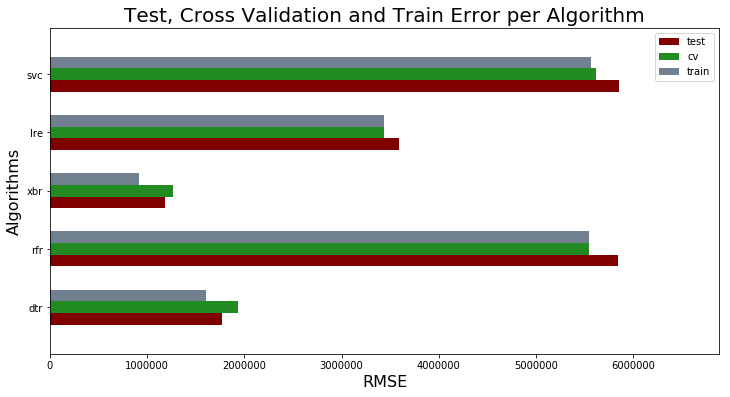

In [191]:
model_names = ['dtr','rfr','xbr','lre','svc']

error = pd.DataFrame(dict(graph=model_names,test_error=test_error, cv_error=cv_error, train_error=train_error)) 

ind = np.arange(len(error))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))
ax.barh(ind, error.test_error, width, color='maroon', label='test')
ax.barh(ind + width, error.cv_error, width, color='forestgreen', label='cv')
ax.barh(ind + 2*width, error.train_error, width, color='slategrey', label='train')
ax.set_xlim(0, max(error.cv_error)+min(error.cv_error))
plt.xlabel('RMSE', fontsize=16)
plt.ylabel('Algorithms', fontsize=16)
plt.title('Test, Cross Validation and Train Error per Algorithm',fontsize=20)

ax.set(yticks=ind + width, yticklabels=error.graph, ylim=[2*width - 1, len(error)])
ax.legend()

plt.show()


In [192]:
error

,graph,test_error,cv_error,train_error
0,dtr,1769111.0,1933184.0,1601429.0
1,rfr,5837386.0,5540553.0,5540532.0
2,xbr,1186330.0,1265565.0,915878.0
3,lre,3587924.0,3438748.0,3434508.0
4,svc,5854694.0,5619461.0,5560873.0


Extreme Gradient Boosting delivers by far the lowest RMSE amongst our models, even though it shows some variance due to underfitting (based on CV and test error comparison). The most stable models, but with a significantly higher RMSE than XGBoost, are Linear Regression, Random Forest and Support Vector Regression. Decision Tree has a relatively low RMSE, but shows signs of high variance. 

Considering the high variance of the Decision Tree and the high bias (RMSE) of Support Vector Regressor, Linear Regression and Random Forest, we decide to accept the variance in XGBoost in favour of the lower overall bias this model seems to have.

## 4.) Using models for final prediction

**Putting the prediction into business presepective:**<br>
In this step we are loading the pickle we have derived from the anomaly detection algorithm. In terms of business this means the clubs has

1.) Selected a subset of players based either on position and overall skill or based on a similar player and<br>
2.) Our anomaly detection model has identified under- and overvalued players amongst the previously defined subset.

The subset of undervalued players is now used to predict these players instrinsic value, so the club gets an idea about how high the first bid for this player should be.

**Technical perspective:**<br>
From a technical perspective, we are loading the subset of undervalued players and apply the same transformations to it as we did for the training set. We then use the transformed subset to predict the players intrinsic value and save the results in a csv file to give to the club as a final report.

In [193]:
with open('undervalue_players.pkl', 'rb') as f:
    undervalued_players = pickle.load(f)

In [194]:
with open('predictors_anomaly.pkl', 'rb') as f:
    predictors_anomaly = pickle.load(f)

Extracting the subset of undervalued players from predictors_anomaly data frame.

In [195]:
predictors_anomaly_processed=predictors_anomaly[predictors_anomaly['ID'].isin(list(undervalued_players['ID']))].copy()

In [196]:
predictors_anomaly_processed.head()

,ID,Age,Overall,Potential,Value,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,anomaly,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
1045,1045,31,77,77,7500000.0,2094,1,3.0,4.0,4.0,1,14.0,0,1,2,178,168,73,73,73,76,76,76,76,76,77,77,77,76,75,75,75,76,69,70,70,70,69,67,67,67,67,67,77.0,71.0,65.0,79.0,78.0,79.0,79.0,64.0,78.0,80.0,75.0,68.0,81.0,74.0,76.0,75.0,78.0,59.0,68.0,75.0,80.0,61.0,77.0,80.0,73.0,79.0,69.0,63.0,60.0,11.0,7.0,11.0,12.0,11.0,1.500000,3,74.0,76.0,74.8,71.0,75.000000,64.000000,10.4,0,1,2,3,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1443,1443,33,76,76,4700000.0,2001,1,2.0,3.0,4.0,0,19.0,706,0,1,178,165,72,72,72,75,74,74,74,75,74,74,74,74,71,71,71,74,65,63,63,63,65,62,57,57,57,62,75.0,73.0,59.0,80.0,61.0,74.0,86.0,79.0,69.0,77.0,76.0,77.0,78.0,74.0,73.0,73.0,64.0,78.0,68.0,74.0,71.0,42.0,71.0,72.0,81.0,72.0,50.0,52.0,47.0,8.0,8.0,8.0,11.0,12.0,1.222222,2,69.6,77.0,75.6,71.4,68.166667,49.666667,9.4,0,1,2,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2802,2802,32,73,73,2300000.0,2050,0,3.0,3.0,3.0,0,44.0,74,0,3,180,174,69,69,69,72,71,71,71,72,74,74,74,72,76,76,76,72,68,71,71,71,68,67,67,67,67,67,82.0,61.0,67.0,83.0,70.0,73.0,83.0,81.0,85.0,82.0,60.0,53.0,69.0,69.0,75.0,80.0,74.0,54.0,72.0,80.0,71.0,71.0,65.0,80.0,73.0,81.0,40.0,72.0,70.0,16.0,7.0,9.0,8.0,15.0,1.444444,3,72.6,80.8,65.2,72.0,73.500000,60.666667,11.0,0,1,2,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [197]:
train_predictors_val.head()

,Overall,Potential,Special,International Reputation,Real Face,BallControl,Reactions,Vision,Composure,Club_Reputation,Mentality,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
2540,1.121234,1.736760,1.087923,1,0,0.879658,0.683807,1.321442,0.468988,0.309200,0.996850,0,0,0,1
14643,-0.904369,-1.845045,-0.259031,1,0,0.099739,-0.758910,-1.366165,-1.635112,-0.505285,-0.615435,1,0,0,0
6185,0.397804,0.271476,0.548407,1,0,0.819664,-0.093041,0.684904,0.907342,-0.505285,0.204371,0,0,0,1
531,1.989350,1.411141,1.983446,2,1,1.299614,2.015546,1.887254,2.047063,0.580695,2.130915,0,0,0,1
4458,0.687176,-0.054143,1.069572,1,0,0.699677,0.794785,0.967810,0.819671,-0.505285,1.174475,1,0,0,0


### 4.1) Preparing subset

First, we are dropping all features that we did not use to train our final models. Also, we are transforming the categorical features to type categorical (if they were not already of type categorical).

In [198]:
predictors_anomaly_processed=predictors_anomaly_processed[train_predictors_val.columns]
predictors_anomaly_processed[['International Reputation','Real Face']]=predictors_anomaly_processed[['International Reputation','Real Face']].astype('category')

Next, we are scaling all continuous features and back-transform categorical features to int (as the model does not accept categorical input).

In [199]:
scaler = StandardScaler()

predictors_anomaly_processed[predictors_anomaly_processed.select_dtypes(include=['float64','float32','int64','int32'], exclude=['category']).columns] = scaler.fit_transform(predictors_anomaly_processed.select_dtypes(include=['float64','float32','int64','int32'], exclude=['category']))


In [200]:
predictors_anomaly_processed[predictors_anomaly_processed.select_dtypes(include='category').columns]=predictors_anomaly_processed[predictors_anomaly_processed.select_dtypes(include='category').columns].astype('int')

In [201]:
predictors_anomaly_processed

,Overall,Potential,Special,International Reputation,Real Face,BallControl,Reactions,Vision,Composure,Club_Reputation,Mentality,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
1045,0.980581,0.980581,1.202217,3,1,0.162221,0.707107,0.707107,0.431934,0.92582,0.947282,0,0,0,1
1443,0.392232,0.392232,-1.246094,2,0,-1.297771,0.707107,-1.414214,-1.382189,-1.38873,-1.383032,0,1,0,0
2802,-1.372813,-1.372813,0.043877,3,0,1.135550,-1.414214,0.707107,0.950255,0.46291,0.435750,0,0,0,1


Now that we have prepared our final data frame, we can move on to predicting the players values.

### 4.2) Final bid recommendation (prediction)

In [211]:
predictions = abs(xbr.predict(predictors_anomaly_processed))

recommendation = pd.concat([pd.DataFrame(undervalued_players['ID']), pd.DataFrame(undervalued_players['Name']), pd.DataFrame(predictions)], axis = 'columns')

recommendation.columns = ['ID', 'Name', 'Bid Recommendation']
recommendation.to_csv('UndervaluedPlayers_BidRecommendation.csv', header = True, index = False)